In [1]:
import pandas as pd

# Define the path to data in Google Drive
file_path = '/content/drive/MyDrive/Text_Mining/sms_data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=0)

**Data Exploration**

In [2]:
df.head(10)

,Text,Spam
0,99923 is your one time password to proceed on ...,0
1,"Sir, please don't send mail to jannu.. few mor...",0
2,Paytm never calls you asking for OTP. Sharing ...,0
3,"Sir,\nFor evening party are you going with yo...",0
4,"Dear Client , your account has been activated ...",0
5,No not now,0
6,I don't use whatsApp,0
7,Shall we go shah ghouse restaurant?,0
8,"Dear IndiGo Customer, fly to Nairobi with retu...",1
9,Thanks for the cheque but pls don't forget abo...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    3068 non-null   object
 1   Spam    3068 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.1+ KB


**Text Preprocessing**

Removing Sensitive information like Social security number, mobile number, email address, credit card numbers and bank account numbers

In [4]:

import re

# Define a function to remove sensitive information
def remove_sensitive_info(text):
    # Remove phone numbers
    text = re.sub(r'\b\+\d{10,12}\b|\b\d{9,11}\b', '', text)

    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,3}\b', '', text)

    # Remove social security number, credit card numbers and bank account numbers
    # Assuming length of account number is 10 to 16 digits
    # Assuming social security number is 10 to 16 digits
    # Credit card number is 16 digits
    text = re.sub(r'\b\d{10,16}\b', '', text)

    # Remove OTPs(one time passwords) (4 to 6 digits)
    text = re.sub(r'\b\d{4,6}\b', '', text)

    return text

# Apply the function to the 'Text'
df['Text'] = df['Text'].apply(remove_sensitive_info)

In [5]:
# Check for rows with sensitive information and print them
# This code should not print anything if the sensitive information is removed.
for index, row in df.iterrows():
    text = row['Text']
    if re.search(r'\b\+\d{10,12}\b|\b\d{9,11}\b', text) or re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,3}\b', text):
        print(f"Row {index}: {text}")

Lowercasing, removing punctuations & special characters, tokenization, removing stop words and Lemmatization.

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove punctuations and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
# example usage of the above function "preprocess_text"
tokens = preprocess_text(df['Text'].iloc[0])
print(tokens)

['one', 'time', 'password', 'proceed', 'phonepe', 'valid', '10', 'minutes', 'share', 'otp', 'anyone', 'gzbmdyq76e3']


**Exploratory Data Analysis**

In [8]:
# counting spam and non-spam SMS's. '1' indicates spam and 'o' indicates non-spam.
print(df['Spam'].value_counts())

0    2669
1     399
Name: Spam, dtype: int64


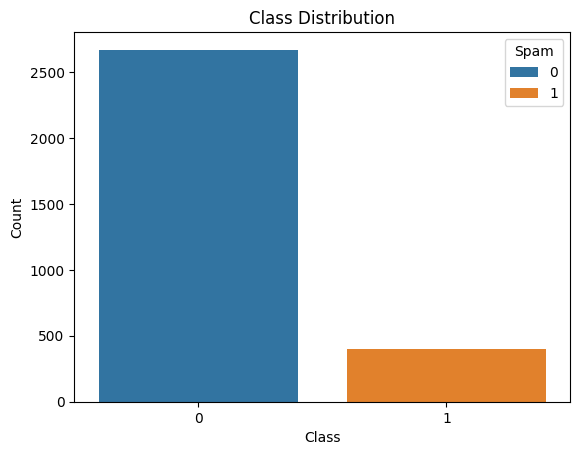

In [9]:
# Visualize the counts

import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Spam', data=df, hue="Spam")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

The dataset is imbalanced, with a significantly higher number of non-spam (class 0) records compared to spam (class 1) records.

**Text Representations:**

TF-IDF Vectorization:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_tfidf = df.copy()

# Apply the preprocessing function to the 'Text' column
df_tfidf['Processed_Text'] = df_tfidf['Text'].apply(preprocess_text)

# Join the preprocessed tokens into a single string for each document
df_tfidf['Processed_Text_Joined'] = df_tfidf['Processed_Text'].apply(' '.join)

# Convert the preprocessed text into numerical features using TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_tfidf['Processed_Text_Joined'])
y_tfidf = df_tfidf['Spam']

Word Embeddings:

In [11]:
from gensim.models import Word2Vec
import numpy as np

# Apply the preprocessing function to the 'Text' column
df_word2vec = df.copy()
df_word2vec['Processed_Text'] = df_word2vec['Text'].apply(preprocess_text)

# Train Word2Vec model
embedding_size = 100
word2vec_model = Word2Vec(sentences=df_word2vec['Processed_Text'], vector_size=embedding_size, window=5, min_count=1, workers=4)

# Function to get the document vector by averaging the word vectors
def get_doc_vector(doc, model):
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    if not word_vectors:
        # If no words found in the model's vocabulary, return a vector of zeros
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Get document vectors for the entire dataset
X_word2vec = np.vstack([get_doc_vector(doc, word2vec_model) for doc in df_word2vec['Processed_Text']])
y_word2vec = df_word2vec['Spam']

Splitting the data into train and test

In [12]:
# Split the data into train and test sets with a balanced proportion of each label
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# For TF-IDF Vectorization
for train_index, test_index in stratified_split.split(X_tfidf, y_tfidf):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train_tfidf, y_test_tfidf = y_tfidf.iloc[train_index], y_tfidf.iloc[test_index]

# For Word2Vec Vectorization
for train_index, test_index in stratified_split.split(X_word2vec, y_word2vec):
    X_train_word2vec, X_test_word2vec = X_word2vec[train_index], X_word2vec[test_index]
    y_train_word2vec, y_test_word2vec = y_word2vec.iloc[train_index], y_word2vec.iloc[test_index]

**Methods**

### Dummy Classifier with TF-IDF Vectorization:

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Create and fit the Random Classifier for TF-IDF Vectorization
random_clf_tfidf = DummyClassifier(strategy="uniform", random_state=42)
random_clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predictions
y_pred_tfidf = random_clf_tfidf.predict(X_test_tfidf)
y_proba_tfidf = random_clf_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Evaluation metrics for TF-IDF Vectorization
accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
roc_auc_tfidf = roc_auc_score(y_test_tfidf, y_proba_tfidf)
classification_report_tfidf = classification_report(y_test_tfidf, y_pred_tfidf)

# ROC Curve for TF-IDF Vectorization
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test_tfidf, y_proba_tfidf)

# Print results for TF-IDF Vectorization
print("TF-IDF Vectorization Results:")
print(f"Accuracy: {accuracy_tfidf:.4f}")
print(f"ROC AUC Score: {roc_auc_tfidf:.4f}")

TF-IDF Vectorization Results:
Accuracy: 0.4902
ROC AUC Score: 0.5000


### Dummy Classifier with Word2Vec Vectorization

In [14]:

# Create and fit the Random Classifier for Word2Vec Vectorization
random_clf_word2vec = DummyClassifier(strategy="uniform", random_state=42)
random_clf_word2vec.fit(X_train_word2vec, y_train_word2vec)

# Predictions
y_pred_word2vec = random_clf_word2vec.predict(X_test_word2vec)
y_proba_word2vec = random_clf_word2vec.predict_proba(X_test_word2vec)[:, 1]

# Evaluation metrics for Word2Vec Vectorization
accuracy_word2vec = accuracy_score(y_test_word2vec, y_pred_word2vec)
roc_auc_word2vec = roc_auc_score(y_test_word2vec, y_proba_word2vec)
classification_report_word2vec = classification_report(y_test_word2vec, y_pred_word2vec)

# ROC Curve for Word2Vec Vectorization
fpr_word2vec, tpr_word2vec, _ = roc_curve(y_test_word2vec, y_proba_word2vec)

# Print results for Word2Vec Vectorization
print("Word2Vec Vectorization Results:")
print(f"Accuracy: {accuracy_word2vec:.4f}")
print(f"ROC AUC Score: {roc_auc_word2vec:.4f}")

Word2Vec Vectorization Results:
Accuracy: 0.4902
ROC AUC Score: 0.5000


###Support Vector Classifier with TF-IDF Vectorization:

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn.svm import SVC

# Define the SVM model
svm_model = SVC(probability=True)

# Define the hyperparameter grid for SVM
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Create an instance of GridSearchCV for SVM
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='roc_auc')

# Fit the grid search on the training data
grid_search_svm.fit(X_train_tfidf, y_train_tfidf)

# Get the best SVM model from the grid search
best_svm_model = grid_search_svm.best_estimator_

# Make predictions on the test data
y_pred_svm = best_svm_model.predict(X_test_tfidf)
y_pred_proba_svm = best_svm_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the model
accuracy_svm = accuracy_score(y_test_tfidf, y_pred_svm)
classification_report_svm = classification_report(y_test_tfidf, y_pred_svm)
auc_svm = roc_auc_score(y_test_tfidf, y_pred_proba_svm)

# Print results
print(f"Best SVM Model: {best_svm_model}")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"AUC: {auc_svm:.4f}")

Best SVM Model: SVC(C=10, probability=True)
Accuracy: 0.9577
AUC: 0.9863


### Support Vector Classifier with Word2Vec Vectorization:

In [17]:
# Define the SVM model
svm_model_word2vec = SVC(probability=True)

# Define the hyperparameter grid for SVM
param_grid_svm_word2vec = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Create an instance of GridSearchCV for SVM with Word2Vec
grid_search_svm_word2vec = GridSearchCV(svm_model_word2vec, param_grid_svm_word2vec, cv=5, scoring='roc_auc')

# Fit the grid search on the training data
grid_search_svm_word2vec.fit(X_train_word2vec, y_train_word2vec)

# Get the best SVM model from the grid search
best_svm_model_word2vec = grid_search_svm_word2vec.best_estimator_

# Make predictions on the test data
y_pred_svm_word2vec = best_svm_model_word2vec.predict(X_test_word2vec)
y_pred_proba_svm_word2vec = best_svm_model_word2vec.predict_proba(X_test_word2vec)[:, 1]

# Evaluate the model
accuracy_svm_word2vec = accuracy_score(y_test_word2vec, y_pred_svm_word2vec)
classification_report_svm_word2vec = classification_report(y_test_word2vec, y_pred_svm_word2vec)
auc_svm_word2vec = roc_auc_score(y_test_word2vec, y_pred_proba_svm_word2vec)

# Print results
print(f"Best SVM Model with Word2Vec: {best_svm_model_word2vec}")
print(f"Accuracy: {accuracy_svm_word2vec:.4f}")
print(f"AUC: {auc_svm_word2vec:.4f}")

Best SVM Model with Word2Vec: SVC(C=10, probability=True)
Accuracy: 0.9007
AUC: 0.9508


### Random Forest Classifier with TF-IDF Vectorization

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
random_forest_model_tfidf = RandomForestClassifier()

# Define the hyperparameter grid for Random Forest
param_grid_rf_tfidf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of GridSearchCV for Random Forest
grid_search_rf_tfidf = GridSearchCV(random_forest_model_tfidf, param_grid_rf_tfidf, cv=5, scoring='roc_auc')

# Fit the grid search on the training data
grid_search_rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Get the best Random Forest model from the grid search
best_rf_model_tfidf = grid_search_rf_tfidf.best_estimator_

# Make predictions on the test data
y_pred_rf_tfidf = best_rf_model_tfidf.predict(X_test_tfidf)
y_pred_proba_rf_tfidf = best_rf_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the model
accuracy_rf_tfidf = accuracy_score(y_test_tfidf, y_pred_rf_tfidf)
classification_report_rf_tfidf = classification_report(y_test_tfidf, y_pred_rf_tfidf)
auc_rf_tfidf = roc_auc_score(y_test_tfidf, y_pred_proba_rf_tfidf)

# Print results
print(f"Best Random Forest Model with TF-IDF: {best_rf_model_tfidf}")
print(f"Accuracy: {accuracy_rf_tfidf:.4f}")
print(f"AUC: {auc_rf_tfidf:.4f}")

Best Random Forest Model with TF-IDF: RandomForestClassifier(min_samples_split=5)
Accuracy: 0.9642
AUC: 0.9882


### Random Forest Classifier with Word2Vec Vectorization

In [19]:
# Define the Random Forest model
random_forest_model_word2vec = RandomForestClassifier()

# Define the hyperparameter grid for Random Forest
param_grid_rf_word2vec = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of GridSearchCV for Random Forest
grid_search_rf_word2vec = GridSearchCV(random_forest_model_word2vec, param_grid_rf_word2vec, cv=5, scoring='roc_auc')

# Fit the grid search on the training data
grid_search_rf_word2vec.fit(X_train_word2vec, y_train_word2vec)

# Get the best Random Forest model from the grid search
best_rf_model_word2vec = grid_search_rf_word2vec.best_estimator_

# Make predictions on the test data
y_pred_rf_word2vec = best_rf_model_word2vec.predict(X_test_word2vec)
y_pred_proba_rf_word2vec = best_rf_model_word2vec.predict_proba(X_test_word2vec)[:, 1]

# Evaluate the model
accuracy_rf_word2vec = accuracy_score(y_test_word2vec, y_pred_rf_word2vec)
classification_report_rf_word2vec = classification_report(y_test_word2vec, y_pred_rf_word2vec)
auc_rf_word2vec = roc_auc_score(y_test_word2vec, y_pred_proba_rf_word2vec)

# Print results
print(f"Best Random Forest Model with Word2Vec: {best_rf_model_word2vec}")
print(f"Accuracy: {accuracy_rf_word2vec:.4f}")
print(f"AUC: {auc_rf_word2vec:.4f}")

Best Random Forest Model with Word2Vec: RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)
Accuracy: 0.9397
AUC: 0.9739


### XGBoost Classifier with TF-IDF vectorization

In [20]:
from xgboost import XGBClassifier

# Define the XGBoost model
xgb_model_tfidf = XGBClassifier()

# Define the hyperparameter grid for XGBoost
param_grid_xgb_tfidf = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Create an instance of GridSearchCV for XGBoost
grid_search_xgb_tfidf = GridSearchCV(xgb_model_tfidf, param_grid_xgb_tfidf, cv=5, scoring='roc_auc')

# Fit the grid search on the training data
grid_search_xgb_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Get the best XGBoost model from the grid search
best_xgb_model_tfidf = grid_search_xgb_tfidf.best_estimator_

# Make predictions on the test data
y_pred_xgb_tfidf = best_xgb_model_tfidf.predict(X_test_tfidf)
y_pred_proba_xgb_tfidf = best_xgb_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the model
accuracy_xgb_tfidf = accuracy_score(y_test_tfidf, y_pred_xgb_tfidf)
classification_report_xgb_tfidf = classification_report(y_test_tfidf, y_pred_xgb_tfidf)
auc_xgb_tfidf = roc_auc_score(y_test_tfidf, y_pred_proba_xgb_tfidf)

# Print results
print(f"Best XGBoost Model with TF-IDF: {best_xgb_model_tfidf}")
print(f"Accuracy: {accuracy_xgb_tfidf:.4f}")
print(f"AUC: {auc_xgb_tfidf:.4f}")

Best XGBoost Model with TF-IDF: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy: 0.9658
AUC: 0.9855


### XGBoost Classifier with Word2Vec vectorization

In [21]:
# Define the XGBoost model
xgb_model_word2vec = XGBClassifier()

# Define the hyperparameter grid for XGBoost
param_grid_xgb_word2vec = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Create an instance of GridSearchCV for XGBoost
grid_search_xgb_word2vec = GridSearchCV(xgb_model_word2vec, param_grid_xgb_word2vec, cv=5, scoring='roc_auc')

# Fit the grid search on the training data
grid_search_xgb_word2vec.fit(X_train_word2vec, y_train_word2vec)

# Get the best XGBoost model from the grid search
best_xgb_model_word2vec = grid_search_xgb_word2vec.best_estimator_

# Make predictions on the test data
y_pred_xgb_word2vec = best_xgb_model_word2vec.predict(X_test_word2vec)
y_pred_proba_xgb_word2vec = best_xgb_model_word2vec.predict_proba(X_test_word2vec)[:, 1]

# Evaluate the model
accuracy_xgb_word2vec = accuracy_score(y_test_word2vec, y_pred_xgb_word2vec)
classification_report_xgb_word2vec = classification_report(y_test_word2vec, y_pred_xgb_word2vec)
auc_xgb_word2vec = roc_auc_score(y_test_word2vec, y_pred_proba_xgb_word2vec)

# Print results
print(f"Best XGBoost Model with Word2Vec: {best_xgb_model_word2vec}")
print(f"Accuracy: {accuracy_xgb_word2vec:.4f}")
print(f"AUC: {auc_xgb_word2vec:.4f}")

Best XGBoost Model with Word2Vec: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy: 0.9479
AUC: 0.9797


### ROC-AUC Plot

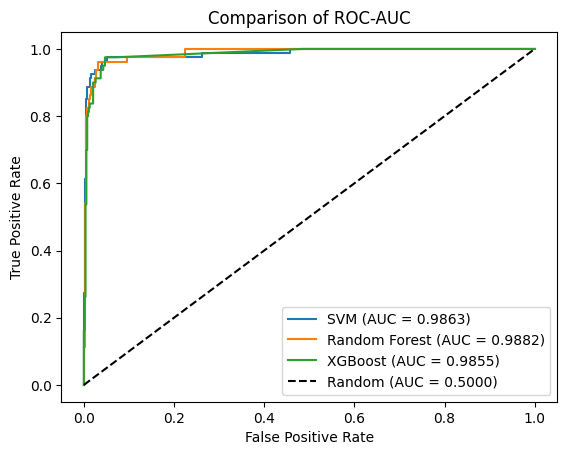

In [25]:
fpr_svm, tpr_svm, _ = roc_curve(y_test_tfidf, y_pred_proba_svm)
fpr_rf_tfidf, tpr_rf_tfidf, _ = roc_curve(y_test_tfidf, y_pred_proba_rf_tfidf)
fpr_xgb_tfidf, tpr_xgb_tfidf, _ = roc_curve(y_test_tfidf, y_pred_proba_xgb_tfidf)

plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})')
plt.plot(fpr_rf_tfidf, tpr_rf_tfidf, label=f'Random Forest (AUC = {auc_rf_tfidf:.4f})')
plt.plot(fpr_xgb_tfidf, tpr_xgb_tfidf, label=f'XGBoost (AUC = {auc_xgb_tfidf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC-AUC')
plt.legend()
plt.show()
